In [1]:
import numpy as np
import matplotlib.pyplot as plt

file_path = "/scratch/phys/sin/sethih1/Extended_TERS_data/planar_oct_2025/planar_again/planar_npz_0.05/train/71601.npz"


data = np.load(file_path)

# List all arrays stored in the file
print("Keys in the .npz file:", data.files)

# Access each array by its key name
for key in data.files:
    print(f"\nKey: {key}")
    print("Array shape:", data[key].shape)
    print("Array data:\n", data[key])



Keys in the .npz file: ['atom_pos', 'atomic_numbers', 'x_pos', 'y_pos', 'frequencies', 'spectrums']

Key: atom_pos
Array shape: (12, 3)
Array data:
 [[ 1.03596484e+00 -9.39655713e-01  2.42616193e-06]
 [ 1.33179122e+00  4.27338393e-01 -2.05275813e-05]
 [-2.95805161e-01 -1.36702123e+00  2.19538638e-05]
 [ 2.95806562e-01  1.36701948e+00  6.04614394e-06]
 [-1.33179037e+00 -4.27342303e-01 -8.47240310e-06]
 [-1.03596513e+00  9.39661789e-01 -2.42618528e-06]
 [ 1.84525043e+00 -1.67377663e+00  3.88410655e-06]
 [ 2.37219100e+00  7.61148618e-01  3.30603767e-05]
 [-5.26883875e-01 -2.43495082e+00 -3.01761262e-05]
 [ 5.26868920e-01  2.43495372e+00 -5.88238971e-05]
 [-2.37219487e+00 -7.61140245e-01  5.49395884e-05]
 [-1.84525740e+00  1.67377103e+00 -4.88409099e-06]]

Key: atomic_numbers
Array shape: (12,)
Array data:
 [6 6 6 6 6 6 1 1 1 1 1 1]

Key: x_pos
Array shape: (256,)
Array data:
 [-9.         -8.92941176 -8.85882353 -8.78823529 -8.71764706 -8.64705882
 -8.57647059 -8.50588235 -8.43529412 -8.3

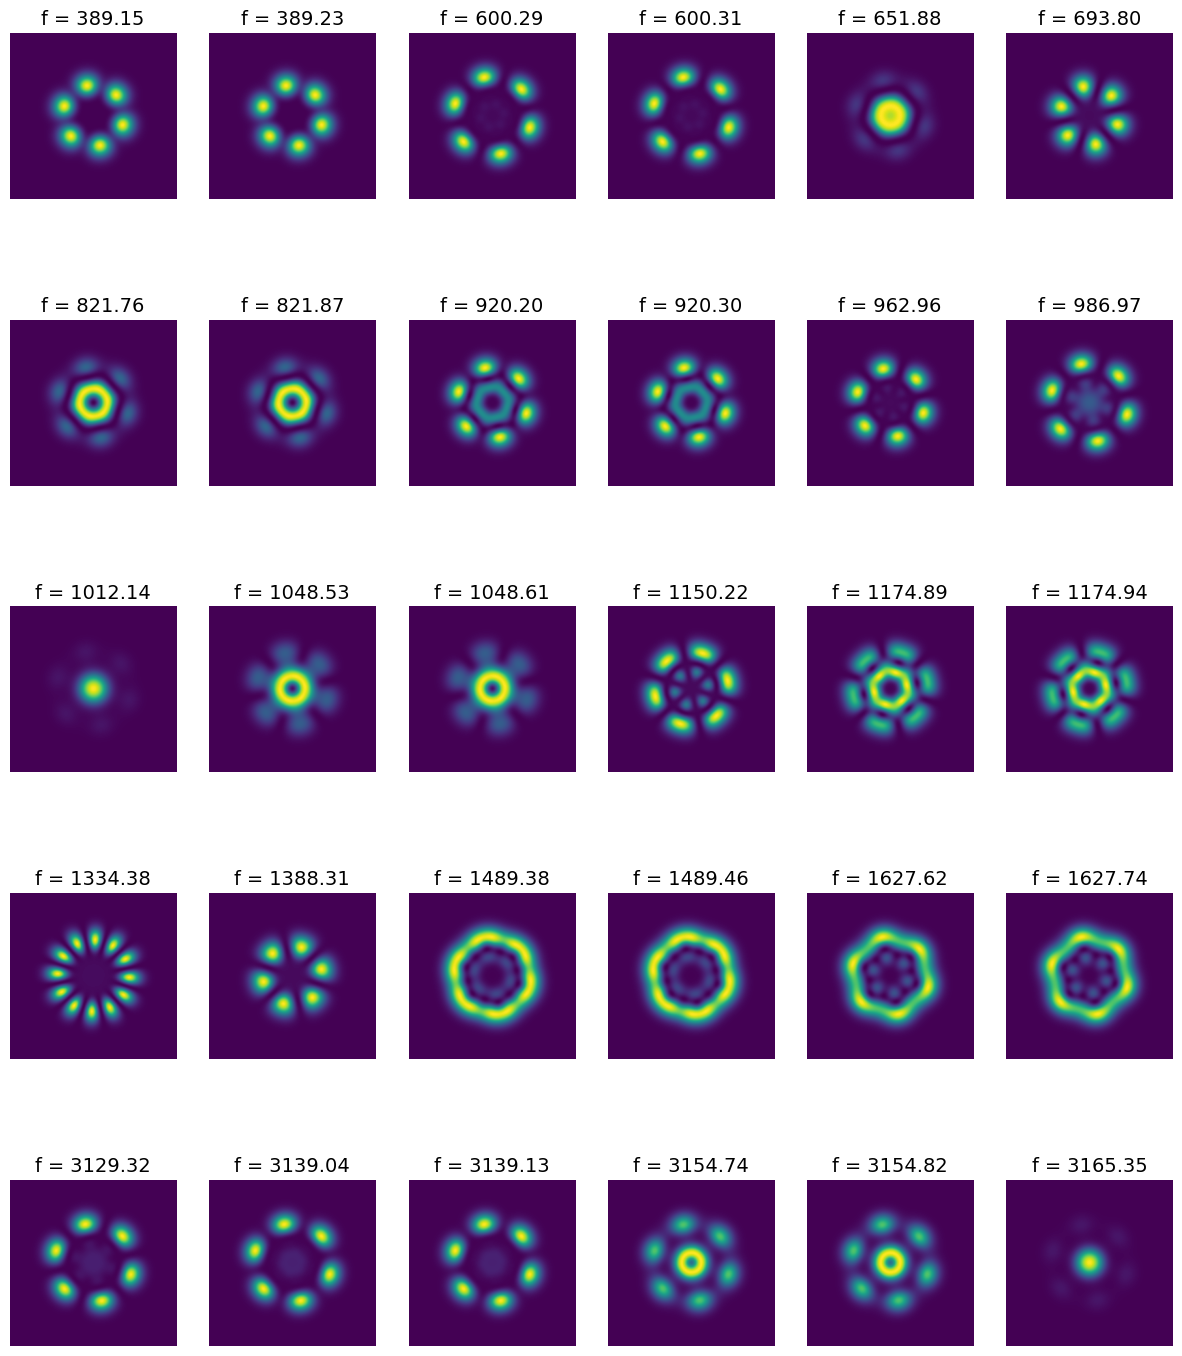

In [2]:
l = data['spectrums'].shape[2]

fig, axs = plt.subplots(5, 6, figsize=(15,18))
axs = axs.flatten()

for i in range(l):
    img = data['spectrums'][:, :, i]
    f = data['frequencies'][i]
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f'f = {f:.2f}', fontsize = 14)

In [4]:
import sys
sys.path.append('../')

In [5]:
from utils.visualization import *
from utils.read_files import *
import os
import torch
from src.models import *
from src.datasets import *
from src.transforms import *
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [6]:
save_flag = False

def visualize_molecule(npz_file):
    
    print(f"Visualizing molecule from {npz_file}...")

    with np.load(npz_file) as data:
        atom_pos = data['atom_pos']
        atomic_numbers = data['atomic_numbers']
        frequencies = data['frequencies']
        spectrums = data['spectrums']



    channels = uniform_channels(spectrums, frequencies)
    channels_glob = channels
    channels = minmax(channels)


    # Visualize the molecule
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    plt.suptitle(r'Atomic Depth-Based Filtering: Depth cutoff 1 $\AA$', fontsize=20)


    # Visualize original molecule
    molecule_visualization_image(np.array(atom_pos), np.array(atomic_numbers), axes=axs[0])
    axs[0].set_title("Original Molecule")
    axs[0].set_frame_on(True)
    
    # Filter the molecule
    filted_atom_pos, filtered_atomic_numbers = remove_disk(atom_pos, atomic_numbers)
    
    # Visualize original molecule
    molecule_visualization_image(np.array(atom_pos), np.array(atomic_numbers), axes=axs[0])
    axs[0].set_title("Original Molecule")
    axs[0].set_frame_on(True)
    
    # Filter the molecule
    filted_atom_pos, filtered_atomic_numbers = remove_disk(atom_pos, atomic_numbers)
    
    # Visualize filtered molecule
    molecule_visualization_image(np.array(filted_atom_pos), np.array(filtered_atomic_numbers), axes=axs[1])
    axs[1].set_title("Filtered Molecule")
    axs[1].set_frame_on(True)
    
    # --- Set shared axis limits so both subplots align ---
    # Combine all positions
    all_positions = np.vstack([atom_pos, filted_atom_pos])
    x_min, y_min = all_positions[:, :2].min(axis=0)
    x_max, y_max = all_positions[:, :2].max(axis=0)
    
    # Add margin
    margin = 2.0
    xlim = (x_min - margin, x_max + margin)
    ylim = (y_min - margin, y_max + margin)
    
    # Apply same limits to both subplots
    for ax in axs:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_aspect('equal')  # Optional: ensure circles look like circles
    
    # Draw a vertical line between subplots
    line_x = 0.5
    fig.add_artist(plt.Line2D([line_x, line_x], [0, 0.88], color='black', linewidth=2, transform=fig.transFigure))
    
    plt.tight_layout()
    



    # Visualize the average of the channels
    print(spectrums.shape)
    average_image = np.zeros((spectrums.shape[0],spectrums.shape[1], 1))  # Initialize an empty average image
    non_empty_channels = [i for i in range(channels.shape[2]) if np.any(channels[:, :, i] != 0)]
    non_empty_channel_images = channels[:, :, non_empty_channels]
    average_image[:, :, 0] = np.mean(non_empty_channel_images, axis=2)
    average_image_log = np.log1p(average_image[:, :, 0])  # For visualization


    plt.figure(figsize=(4, 4))
    ax = plt.gca()

    filtered_atom_pos, filtered_atomic_numbers = remove_disk(atom_pos, atomic_numbers)
    overlay_molecule_on_image(filtered_atom_pos, filtered_atomic_numbers, average_image_log, ax, grid_size=18.0)
    
    basename = os.path.splitext(os.path.basename(npz_file))[0]
    plt.title('Spectral Average')
    #plt.title(f"Molecule {basename} Overlaid on Average Channel")
    plt.tight_layout()

    if save_flag:
        plt.savefig('save_channels.png', transparent=True)
    plt.show()



    # Visualizing each channel

    n_cols = 5
    n_rows = int(np.ceil(len(non_empty_channels) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    axes = axes.flatten()

    for i, idx in enumerate(non_empty_channels):
        overlay_molecule_on_image(filtered_atom_pos, filtered_atomic_numbers, channels[:, :, idx], axes[i], grid_size=18.0)

        indices = (frequencies > (idx * 10 + 1)) & (frequencies < ((idx + 1) * 10 + 1))
        t = ', '.join([str(np.round(frequencies[j],2)) for j in range(len(frequencies)) if indices[j]]) + ' cmˆ-1'
        #axes[i].set_title(f"Channel {idx}, f={frequencies[indices]}")
        axes[i].set_title(f"f={t}")

    # Hide extra subplots
    for j in range(len(non_empty_channels), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


    n_cols = 5
    n_rows = int(np.ceil(len(non_empty_channels) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    axes = axes.flatten()

    for i, idx in enumerate(non_empty_channels):
        image = channels_glob[:, :, idx]
        grid_size = 18.0
        axes[i].imshow(image, cmap='jet', extent=(-grid_size/2, grid_size/2, -grid_size/2, grid_size/2), origin='lower')
        indices = (frequencies > (idx * 10 + 1)) & (frequencies < ((idx + 1) * 10 + 1))
        t = ', '.join([str(np.round(frequencies[j],2)) for j in range(len(frequencies)) if indices[j]]) + ' cmˆ-1'
        axes[i].axis('off')

    # Hide extra subplots
    for j in range(len(non_empty_channels), len(axes)):
        axes[j].axis('off')

    plt.savefig(f"visualization.svg", dpi=600)
    plt.tight_layout()
    plt.show()


    output_dir = "visualization/"
    os.makedirs(output_dir, exist_ok=True)
    
    
    
    
    
    # Extract base name for file prefixes
    basename = os.path.splitext(os.path.basename(npz_file))[0]
    
    # 1) Normalize each channel to [0,1] and save
    normalized_channels = np.zeros_like(non_empty_channel_images)
    for i in range(non_empty_channel_images.shape[2]):
        ch = non_empty_channel_images[:, :, i]
        cmin, cmax = ch.min(), ch.max()
        if cmax > cmin:
            norm_ch = (ch - cmin) / (cmax - cmin)
        else:
            norm_ch = np.zeros_like(ch)
        normalized_channels[:, :, i] = norm_ch
    
        # Save each normalized channel image
        chan_fname = f"{basename}_chan{i:02d}_norm.png"
        plt.imsave(
            os.path.join(output_dir, chan_fname),
            norm_ch,
            cmap='jet',
            origin='lower'
        )
    
    # 2) Sum the normalized channels into one image
    sum_norm = normalized_channels.sum(axis=2)
    
    # 3) Normalize the summed image to [0,1]
    smin, smax = sum_norm.min(), sum_norm.max()
    sum_norm = (sum_norm - smin) / (smax - smin + 1e-8)
    
    # 4) Save the spectral‑sum image
    sum_fname = f"{basename}_sum_norm.png"
    plt.imsave(
        os.path.join(output_dir, sum_fname),
        sum_norm,
        cmap='jet',
        origin='lower'
    )

    
    # 5) (Optional) Display the summed normalized image
    plt.figure(figsize=(4, 4))
    plt.imshow(sum_norm, cmap='jet', origin='lower')
    plt.axis('off')
    #plt.title("Spectral Sum of Normalized Channels")
    plt.title("Spectral Average")
    plt.tight_layout()
    plt.show()

    # Visualize just the original molecule
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    molecule_visualization_image(np.array(atom_pos),
                                 np.array(atomic_numbers),
                                 axes=ax)
    ax.set_frame_on(True)
    plt.tight_layout()

    # Save the original molecule plot
    save_path = os.path.join(output_dir,
                             f"{basename}_original_molecule.png")
    #fig.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()










In [7]:
molecule_id = 140071
npz_file = f'/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/val/{molecule_id}.npz'
npz_file = f'/scratch/phys/sin/sethih1/data_files/final_data_used/test/{molecule_id}.npz'


import numpy as np
import matplotlib.pyplot as plt
import os

def visualize_orig_molecule(npz_file, molecule_id):
    print(f"Visualizing molecule from {npz_file}...")

    # Load data
    with np.load(npz_file) as data:
        atom_pos = data['atom_pos']
        atomic_numbers = data['atomic_numbers']

    # Create figure
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot original molecule
    molecule_visualization_image(np.array(atom_pos), np.array(atomic_numbers), axes=ax)
    ax.set_frame_on(True)

    plt.tight_layout()

    #path = '/scratch/phys/sin/sethih1/runs_ters/all_group_plane_fchk_split_images_ters/posnet_hyperopt_all_50_epochs/augmented/config_hypopt_all/dice_bins_val/best_samples_val/'

    path = '/scratch/phys/sin/sethih1/runs_ters/all_group_plane_fchk_split_images_ters/posnet_hyperopt_all_50_epochs_just_aug_val/augmented/config_hypopt_all/dice_bins_test/best_worst_dice_samples/bottom_10_percent/'


    plt.savefig(path + (str)(molecule_id)+'.png', dpi=600)
    return fig


visualize_orig_molecule(npz_file, molecule_id)

Visualizing molecule from /scratch/phys/sin/sethih1/data_files/final_data_used/test/140071.npz...


In [8]:
def print_files_with_least_atoms(folder_path, top_k=5):
    npz_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]
    atom_counts = []

    for file in npz_files:
        full_path = os.path.join(folder_path, file)
        try:
            atom_pos, _ = read_npz(full_path)
            atom_counts.append((file, len(atom_pos)))
        except Exception:
            continue  # silently skip broken files
        

    atom_counts.sort(key=lambda x: x[1])  # sort by number of atoms

    for file, count in atom_counts[:top_k]:
        print(f"Number of atoms in {file}: ", count)

print_files_with_least_atoms("/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/val/", top_k=25)


KeyboardInterrupt: 

Visualizing molecule from /scratch/phys/sin/sethih1/Extended_TERS_data/planar_oct_2025/planar_again/planar_npz_1.0/test/10388.npz...
(256, 256, 87)
0.0735025817222086 1.227143589713185


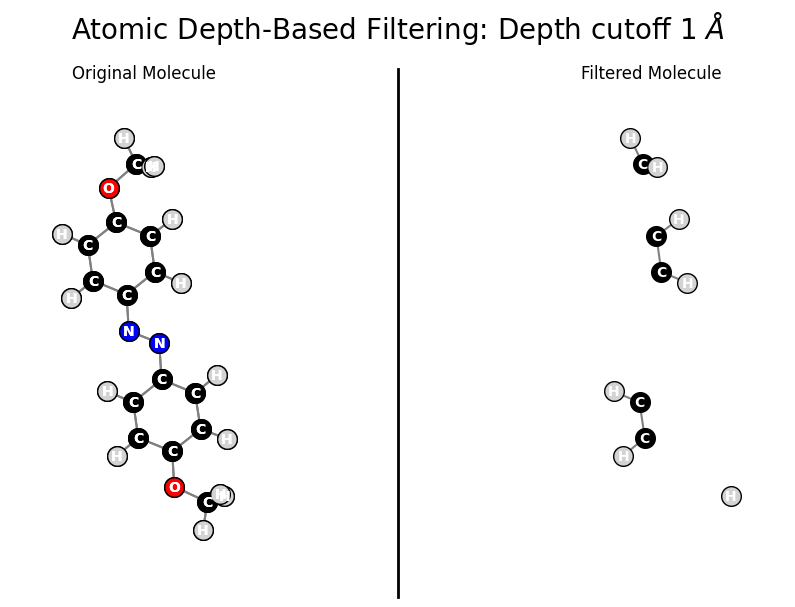

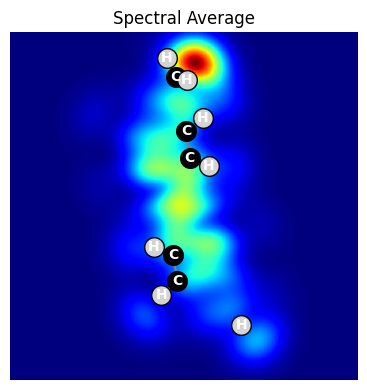

0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0.0735025817222086 1.227143589713185
0

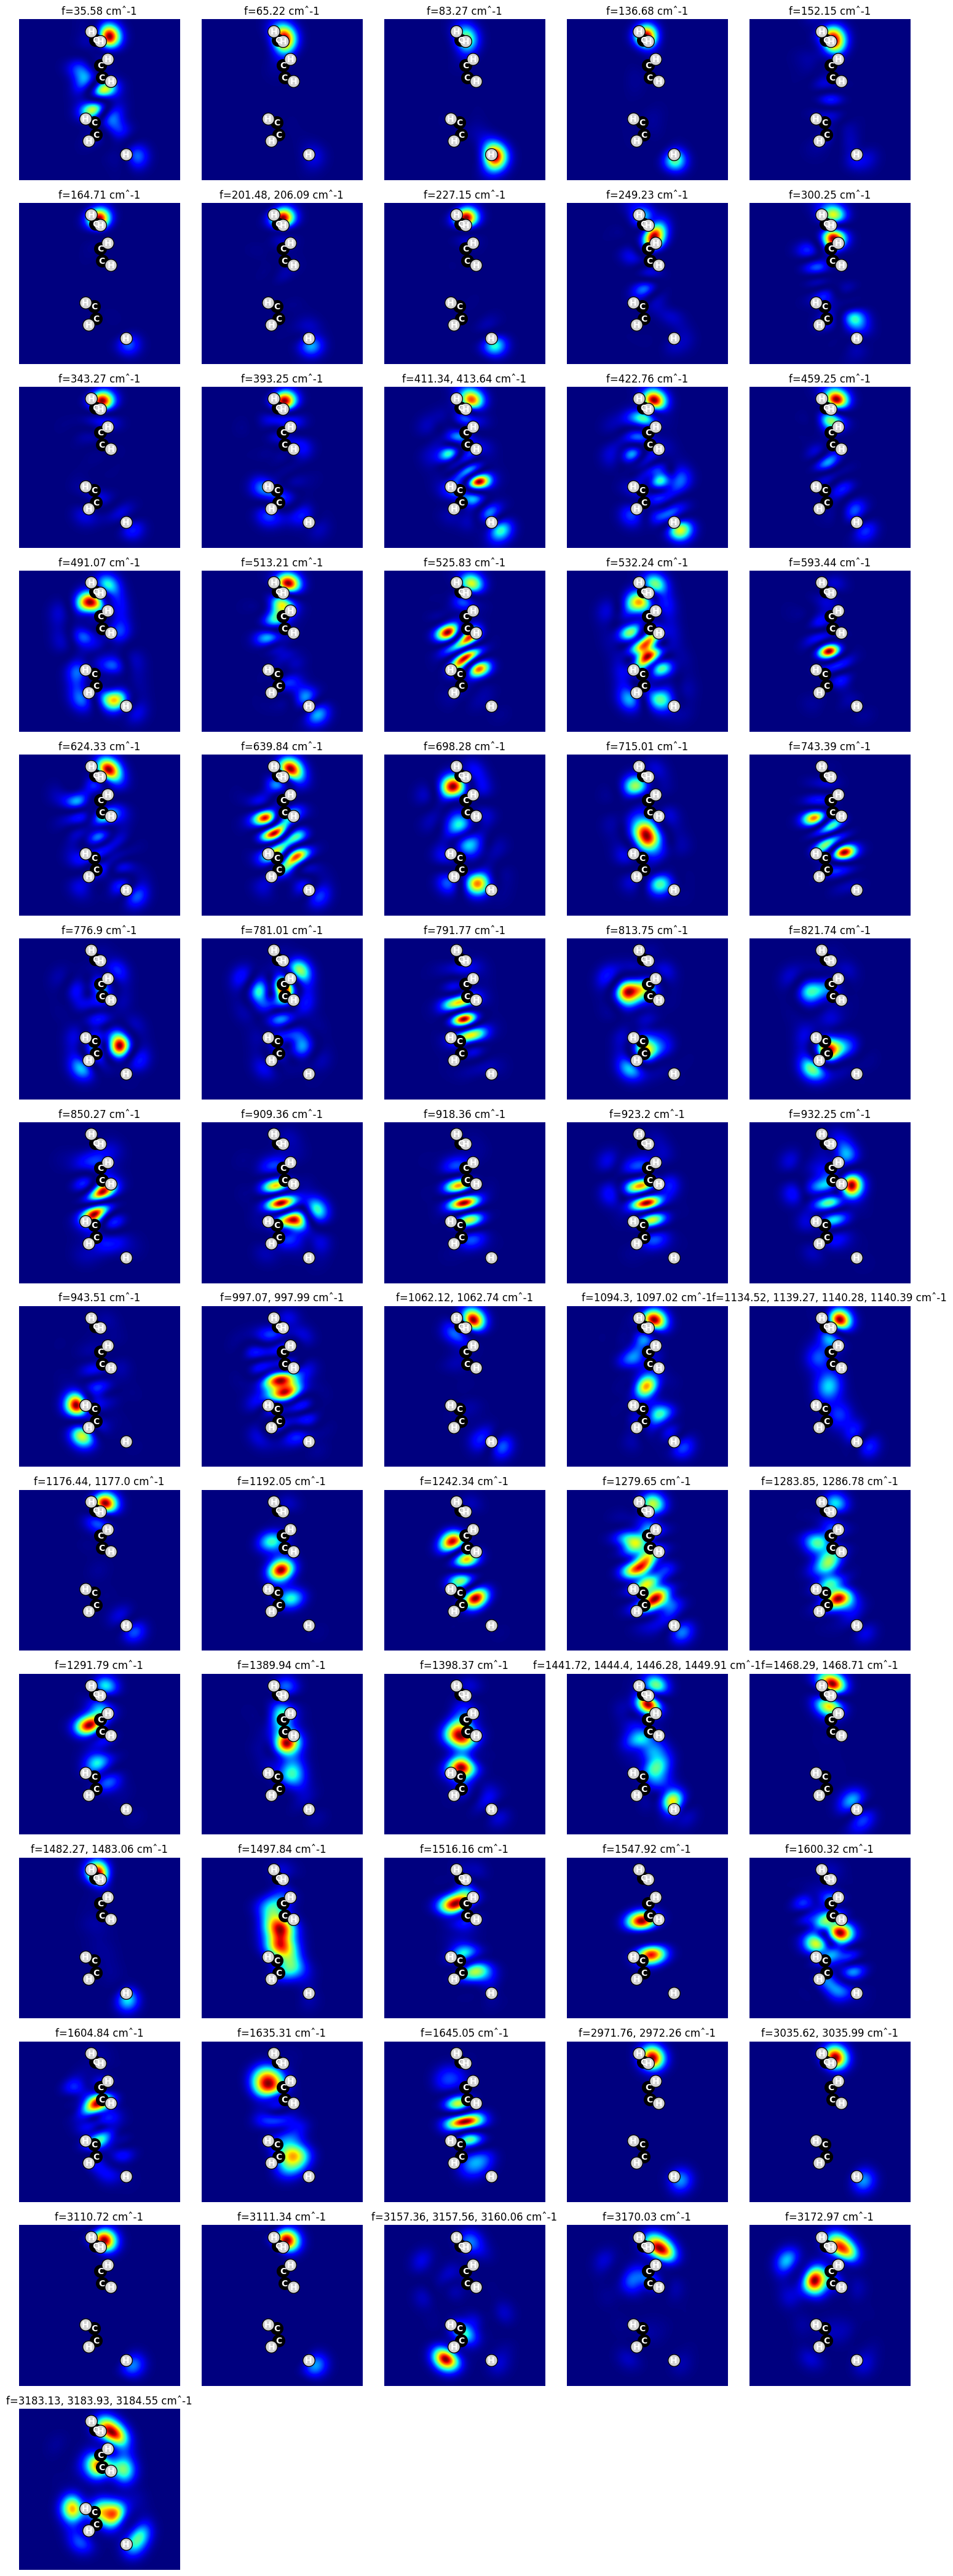

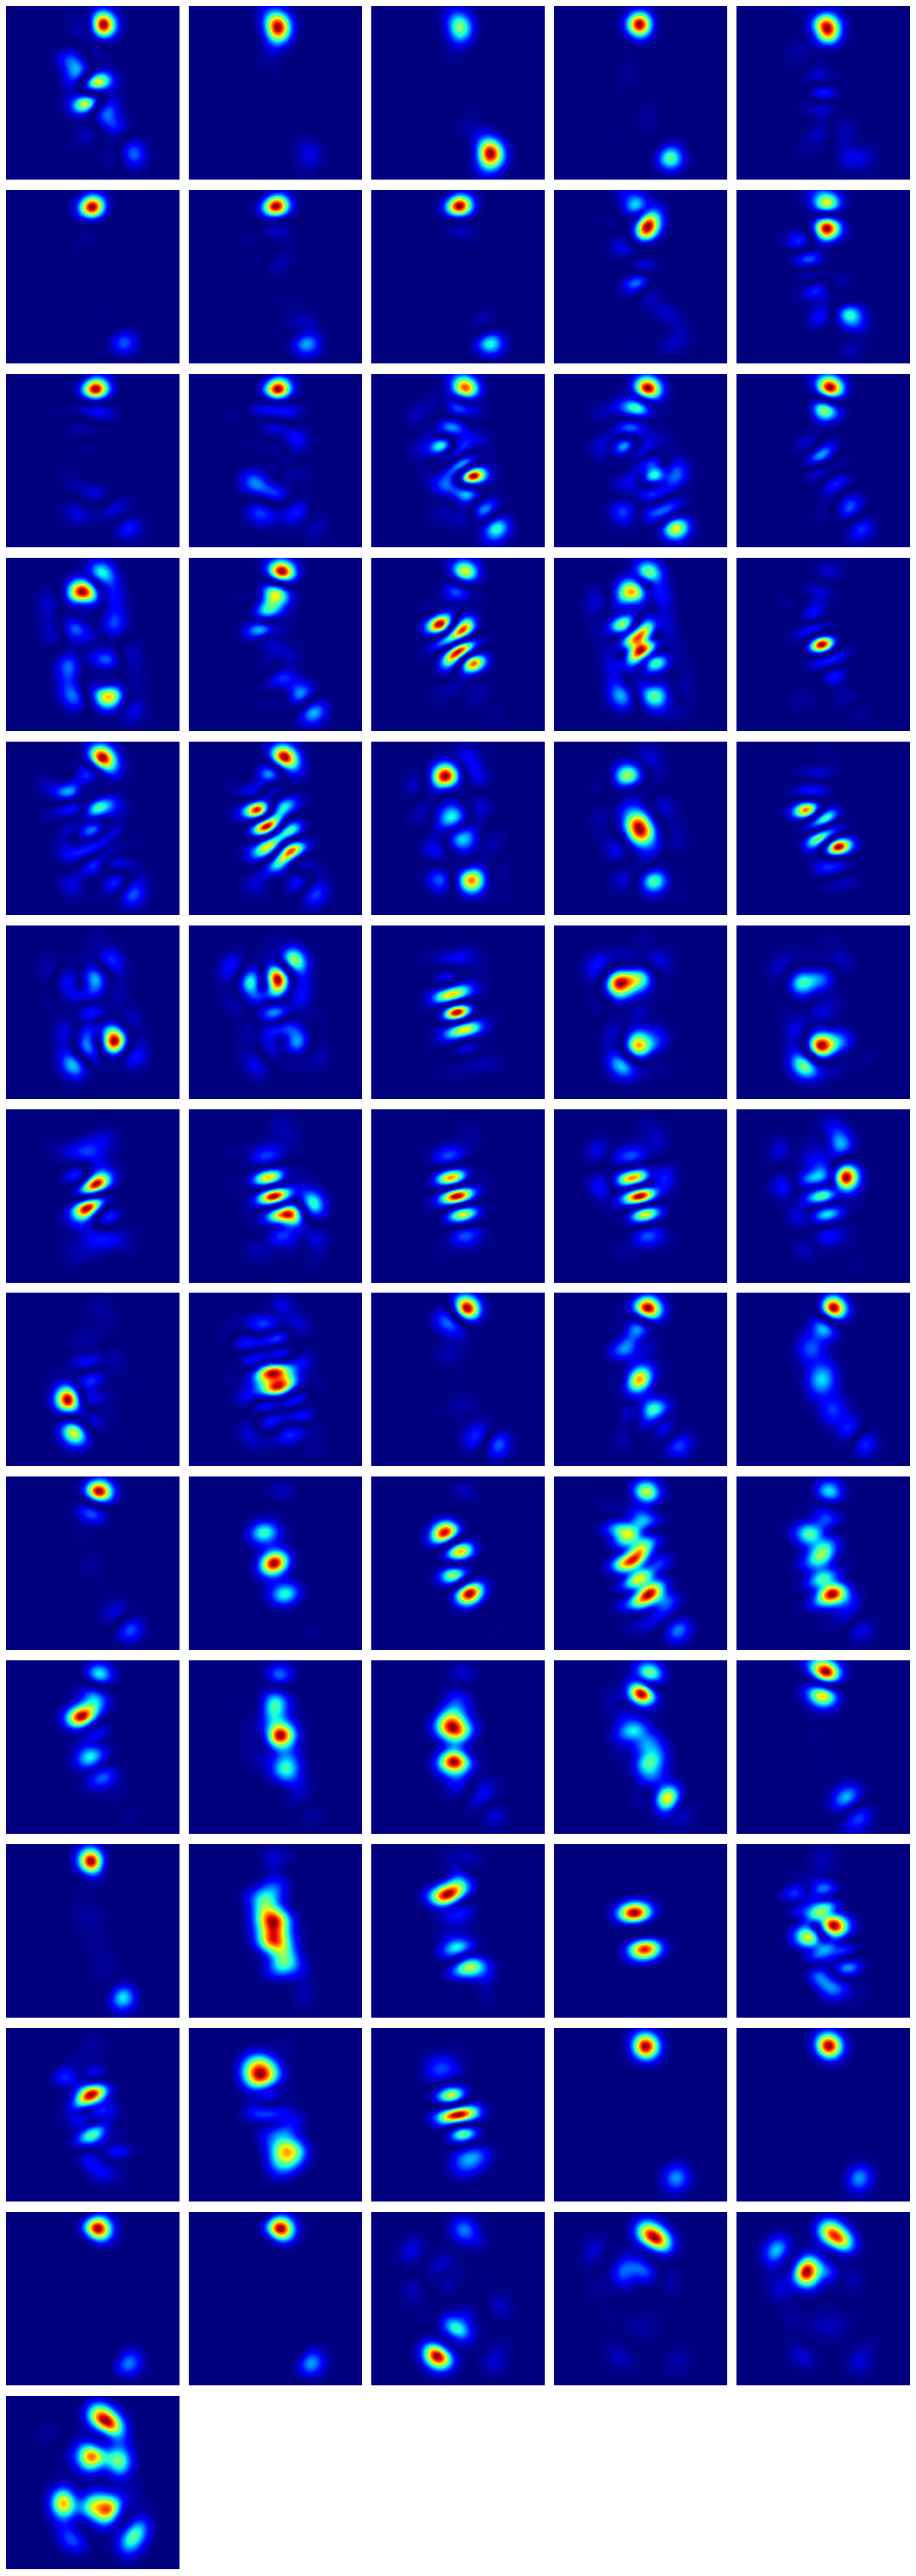

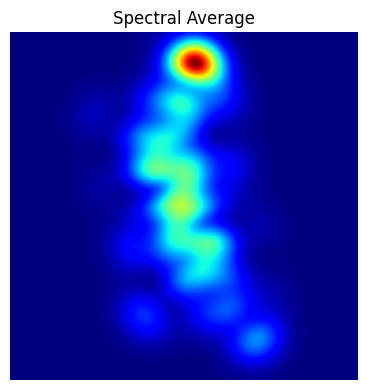

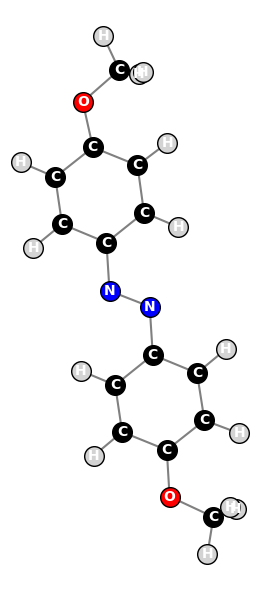

In [9]:
npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/7847.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/old/second_group_images_256/7847.npz'

molecule_id = 7923
npz_file = f'/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/val/{molecule_id}.npz'

npz_file = '/home/sethih1/masque_new/ters_gen/notebooks/molecules/100822.npz'
npz_file = '/scratch/phys/sin/sethih1/Extended_TERS_data/planar_oct_2025/planar_again/planar_npz_1.0/test/13284.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/final_data_used/test/100489.npz'
#npz_file = '/scratch/phys/sin/sethih1/data_files/final_data_used/test/10110.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/final_data_used/train/134591.npz'
npz_file = '/home/sethih1/masque_new/ters_gen/notebooks/interesting_mols/148247.npz'
npz_file = '/scratch/phys/sin/sethih1/Extended_TERS_data/planar_oct_2025/planar_again/planar_npz_1.0/test/13284.npz'

npz_file = "/scratch/phys/sin/sethih1/Extended_TERS_data/planar_oct_2025/planar_again/planar_npz_1.0/test/10388.npz"

visualize_molecule(npz_file)

Visualizing molecule from /scratch/phys/sin/sethih1/data_files/old/planar_molecules_256/train/123178.npz...
(256, 256, 3)


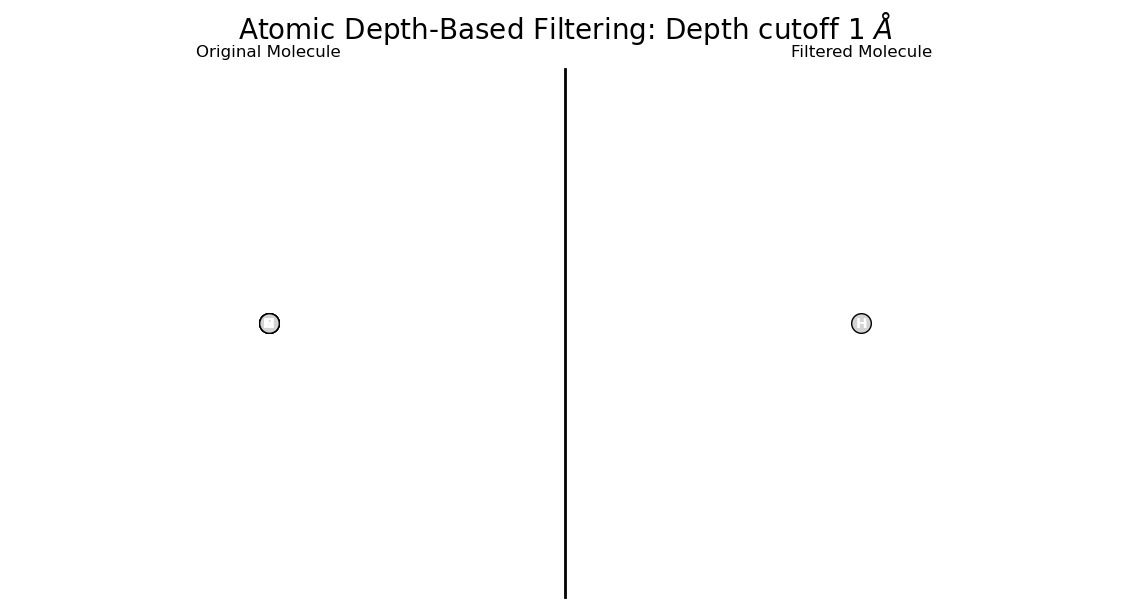

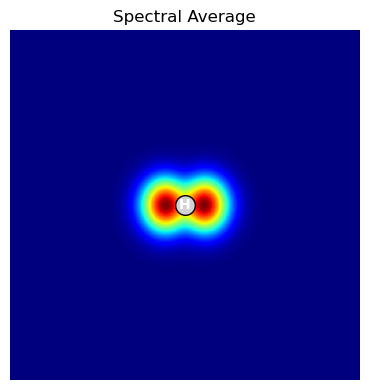

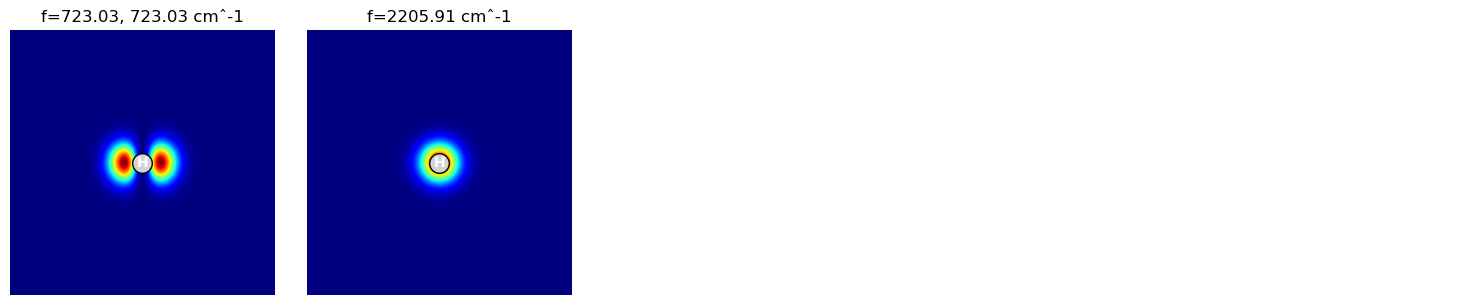

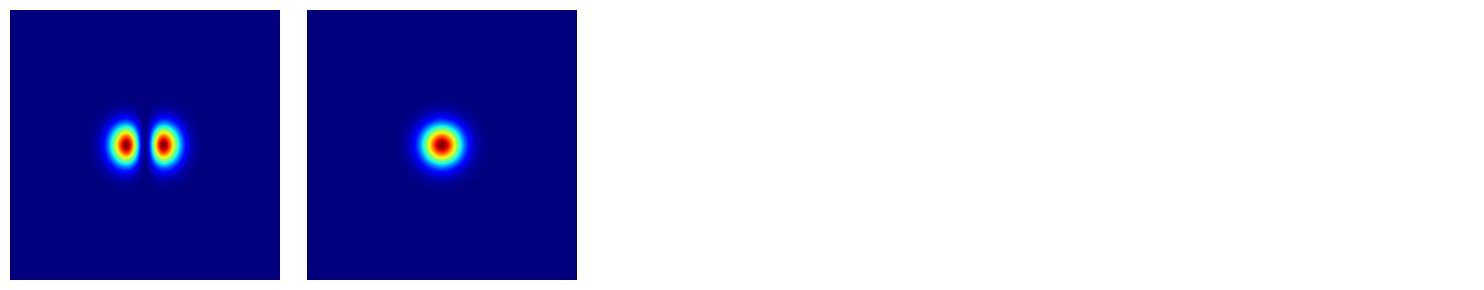

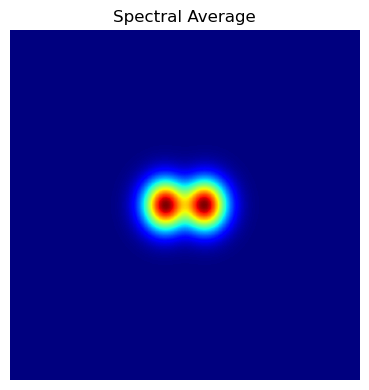

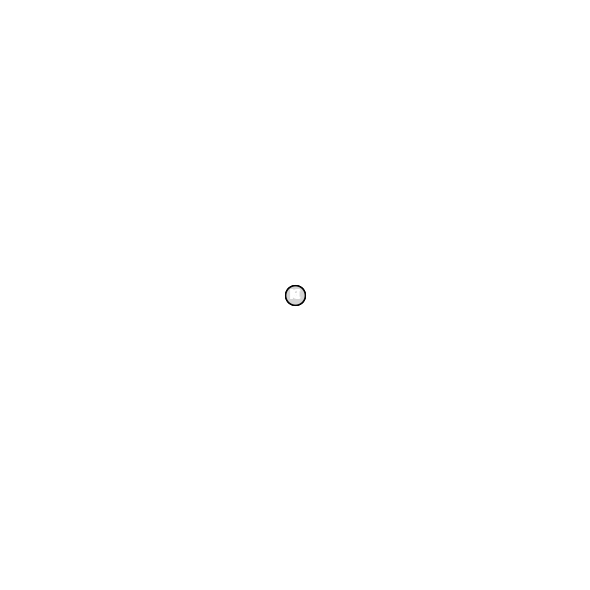

In [ ]:
npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/7847.npz'
npz_file = '/home/sethih1/masque_new/ters_gen/notebooks/vis_molecules/7847 (1).npz'
npz_file = '/home/sethih1/masque_new/ters_gen/notebooks/molecules/123178.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/old/planar_molecules_256/train/123178.npz'
visualize_molecule(npz_file)

In [134]:
model = torch.load(
    #'/scratch/phys/sin/sethih1/models/all_group_plane_fchk_split_images_ters/hyperopt_old/config2/seg_bs_16_lr_0.0005116967471012849_loss_dice_loss.pt',
    '/scratch/phys/sin/sethih1/models/all_group_plane_fchk_split_images_ters/hyperopt/config2/seg_bs_16_lr_0.00040199284987490726_loss_dice_loss.pt',
    map_location=torch.device('cpu' if torch.cuda.is_available() else 'cpu')
)




model = torch.load(
    #'/scratch/phys/sin/sethih1/models/all_group_plane_fchk_split_images_ters/hyperopt_old/config2/seg_bs_16_lr_0.0005116967471012849_loss_dice_loss.pt',
    '/scratch/phys/sin/sethih1/models/all_group_plane_fchk_split_images_ters/posnet_hyperopt_all_50_epochs/augmented/config_hypopt_all/best_model.pt',
    map_location=torch.device('cpu' if torch.cuda.is_available() else 'cpu')
)
#print(model)

In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def normalize_all_weights(model):
    with torch.no_grad():
        for name, module in model.named_modules():
            if hasattr(module, 'weight') and module.weight is not None:
                weight = module.weight
                # Flatten each output unit's weights (e.g., row in Linear, filter in Conv)
                reshaped = weight.view(weight.size(0), -1)  # (out_features, ...)
                norm = reshaped.norm(p=2, dim=1, keepdim=True) + 1e-8  # avoid divide by zero
                normalized = reshaped / norm
                module.weight.copy_(normalized.view_as(weight))


def normalize_entire_model(model):
    # Collect all weights into one big vector
    all_weights = []
    for module in model.modules():
        if hasattr(module, 'weight') and module.weight is not None:
            all_weights.append(module.weight.data.view(-1))

    # Concatenate all weights
    flat_weights = torch.cat(all_weights)
    global_norm = torch.norm(flat_weights, p=2) + 1e-8  # Avoid division by zero

    # Scale each layer’s weights proportionally to preserve direction
    for module in model.modules():
        if hasattr(module, 'weight') and module.weight is not None:
            module.weight.data.div_(global_norm)


def scale_model_weights(model, factor: float):
    with torch.no_grad():
        for module in model.modules():
            if hasattr(module, 'weight') and module.weight is not None:
                #module.weight.data.mul_(factor)
                module.weight.data.add_(factor)


#normalize_all_weights(model)
#normalize_entire_model(model)
scale_model_weights(model, 0.0001)

In [136]:
npz_file = '/home/sethih1/masque_new/ters_gen/notebooks/vis_molecules'

npz_file = '/home/sethih1/masque_new/ters_gen/notebooks/molecules'

data_transform = transforms.Compose([Normalize(), MinimumToZero()])
#num_channels = 400
num_channels = 100
sg_ch = True

#npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/val'

ters_set = Ters_dataset_filtered_skip(
    filename=npz_file,
    frequency_range=[0, 4000],
    num_channels=num_channels,
    std_deviation_multiplier=2,
    sg_ch=sg_ch,
    t_image=data_transform,
    t_freq=None, 
    #flag=False
    flag=True
)

ters_loader = DataLoader(ters_set, batch_size=1, shuffle=False)

In [137]:
for i, data in enumerate(ters_loader):
    if i == 7:  
        batch = data
        break

In [138]:
filename, _, _, images, _, masks = batch 
pred = model(images)

In [139]:
pred_new = torch.sigmoid(pred) > 0.5

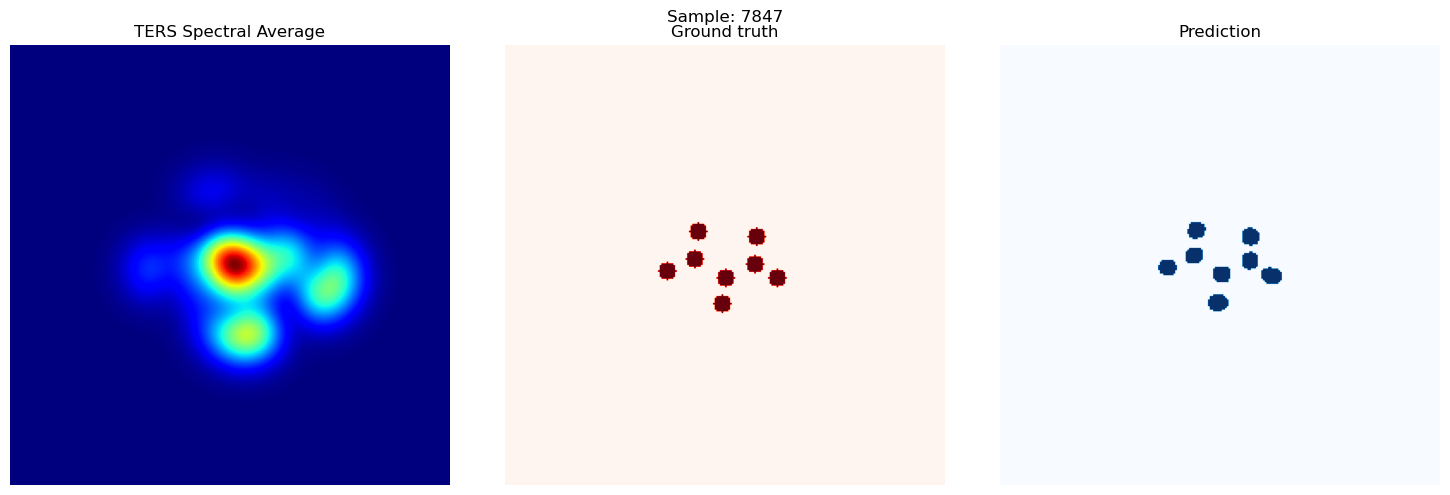

In [140]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original image
ax1.imshow(images.squeeze().mean(dim=0).cpu().numpy(), cmap='jet', origin='lower')
ax1.set_title("TERS Spectral Average")
ax1.axis('off')
ax1.set_facecolor('white')

# Ground truth mask
ax2.imshow(masks.squeeze(0, 1).cpu().numpy(), cmap="Reds", origin = 'lower')
ax2.set_title("Ground truth")
ax2.axis('off')
ax2.set_facecolor('white')

# Prediction
ax3.imshow(pred_new.squeeze().detach().cpu().numpy(), cmap="Blues", origin = 'lower')
ax3.set_title("Prediction")
ax3.axis('off')
ax3.set_facecolor('white')


plt.suptitle(f'Sample: {filename[0]}')
plt.savefig('check.png', transparent=True)

plt.tight_layout()
plt.show()

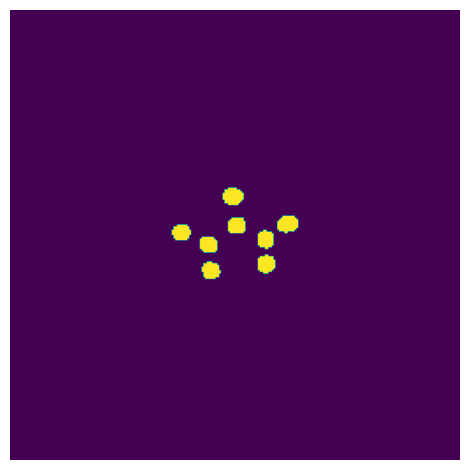

In [141]:
plt.imshow(pred_new.squeeze().detach().numpy(),  cmap='viridis')
plt.axis('off')
plt.gca().set_facecolor('white')
plt.tight_layout()
plt.savefig('pred.svg', dpi=600)

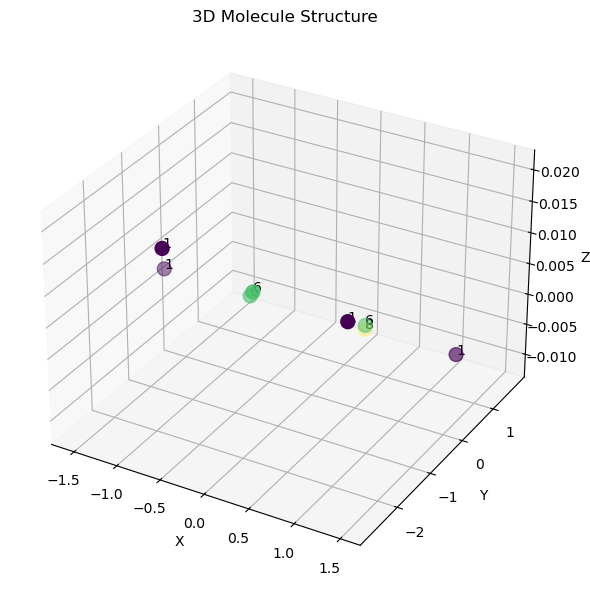

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_molecule_3d(atom_pos, atomic_numbers):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Use atomic number to define color
    scatter = ax.scatter(atom_pos[:, 0], atom_pos[:, 1], atom_pos[:, 2],
                         c=atomic_numbers, cmap='viridis', s=100)

    for i, num in enumerate(atomic_numbers):
        ax.text(atom_pos[i, 0], atom_pos[i, 1], atom_pos[i, 2],
                str(num), size=10, zorder=1, color='black')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title("3D Molecule Structure")
    plt.tight_layout()
    plt.show()


npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/7847.npz'

def read_npz(npz_file):
    with np.load(npz_file) as data:
            atom_pos = data['atom_pos']
            atomic_numbers = data['atomic_numbers']

    return atom_pos, atomic_numbers

atom_pos, atomic_numbers = read_npz(npz_file)
visualize_molecule_3d(np.array(atom_pos), np.array(atomic_numbers))

In [ ]:
import py3Dmol


from ase.data import chemical_symbols


from IPython.display import HTML

def show_and_expose(view):
    """Display the py3Dmol view and expose it to JavaScript."""
    return HTML(f"""
    <div id="myviewer" style="width: 400px; height: 400px;"></div>
    <script>
        let viewer = $3Dmol.createViewer($("#myviewer"), {{backgroundColor: "white"}});
        viewer.addModel({repr(view.getModel().getMolString())}, "xyz");
        viewer.setStyle({{}}, {{stick:{{}}}});
        viewer.zoomTo();
        viewer.render();
        window.viewer = viewer; // 👈 expose it
    </script>
    """)


def to_xyz_string(atom_pos, atomic_numbers, comment='Generated molecule'):
    n_atoms = len(atomic_numbers)
    symbols = [chemical_symbols[z] for z in atomic_numbers]
    lines = [f"{symbols[i]} {atom_pos[i][0]} {atom_pos[i][1]} {atom_pos[i][2]}" for i in range(n_atoms)]
    return f"{n_atoms}\n{comment}\n" + "\n".join(lines)


def show_py3dmol(atom_pos, atomic_numbers):
    xyz_str = to_xyz_string(atom_pos, atomic_numbers)
    view = py3Dmol.view(width=400, height=400)
    view.addModel(xyz_str, 'xyz')
    view.setStyle({'stick': {}})
    view.setBackgroundColor("0x00000000")  # Transparent background
    view.zoomTo()
    view.show()
    
    show_and_expose(view)


show_py3dmol(atom_pos, atomic_numbers)


In [ ]:
npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/7847.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/old/second_group_images_256/7847.npz'
atom_pos, atomic_numbers = read_npz(npz_file)

show_py3dmol(atom_pos, atomic_numbers)

In [ ]:
import numpy as np
import ase.data

def write_xyz(atom_pos, atomic_numbers, filename="molecule.xyz"):
    """
    Writes atom positions and atomic numbers to a .xyz file.
    
    Parameters:
    - atom_pos: Nx3 array of atomic positions
    - atomic_numbers: N array of atomic numbers
    - filename: Name of the output .xyz file
    """
    num_atoms = len(atom_pos)
    with open(filename, 'w') as f:
        f.write(f"{num_atoms}\n")
        f.write("Generated by script\n")
        for num, pos in zip(atomic_numbers, atom_pos):
            symbol = ase.data.chemical_symbols[num]
            f.write(f"{symbol} {pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n")



npz_file = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/7847.npz'

def read_npz(npz_file):
    with np.load(npz_file) as data:
            atom_pos = data['atom_pos']
            atomic_numbers = data['atomic_numbers']

    return atom_pos, atomic_numbers

atom_pos, atomic_numbers = read_npz(npz_file)
write_xyz(atom_pos, atomic_numbers, "output.xyz")


In [ ]:
%%javascript
// Save current py3Dmol viewer as PNG
let viewer = window.viewer || window.$3Dmol.getViewer();
viewer.render();
viewer.pngURI(function(uri) {
    let a = document.createElement('a');
    a.href = uri;
    a.download = "molecule_view.png";
    document.body.appendChild(a);%%javascript
let viewer = window.viewer;
if (viewer) {
    viewer.render();
    viewer.pngURI(function(uri) {
        let a = document.createElement('a');
        a.href = uri;
        a.download = "molecule_view.png";
        document.body.appendChild(a);
        a.click();
        document.body.removeChild(a);
    });
} else {
    alert("Viewer not found. Make sure it was exposed to window.viewer.");
}

    a.click();
    document.body.removeChild(a);
});


In [ ]:
import numpy as np
from ase import Atoms
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
from ase.data import chemical_symbols

def save_molecule_image_png(atom_pos, atomic_numbers, filename='molecule.png'):
    """
    Save molecule as a .png image using ASE and matplotlib.
    
    Parameters:
    - atom_pos: (N, 3) numpy array of atomic positions
    - atomic_numbers: (N,) list or array of atomic numbers
    - filename: output .png filename
    """
    # Convert atomic numbers to symbols
    symbols = [chemical_symbols[z] for z in atomic_numbers]
    
    # Create ASE Atoms object
    molecule = Atoms(symbols=symbols, positions=atom_pos)

    # Plot and save
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_atoms(molecule, ax=ax, rotation=('45x,45y,0z'), radii=0.3, show_unit_cell=False)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Example usage:
save_molecule_image_png(atom_pos, atomic_numbers, 'my_molecule.png')


In [ ]:
import numpy as np
import ase.data
import os
from glob import glob

def write_xyz(atom_pos, atomic_numbers, filename="molecule.xyz"):
    """
    Writes atom positions and atomic numbers to a .xyz file.
    
    Parameters:
    - atom_pos: Nx3 array of atomic positions
    - atomic_numbers: N array of atomic numbers
    - filename: Name of the output .xyz file
    """
    num_atoms = len(atom_pos)
    with open(filename, 'w') as f:
        f.write(f"{num_atoms}\n")
        f.write("Generated by script\n")
        for num, pos in zip(atomic_numbers, atom_pos):
            symbol = ase.data.chemical_symbols[num]
            f.write(f"{symbol} {pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n")

def read_npz(npz_file):
    """
    Reads atomic positions and numbers from a .npz file.
    """
    with np.load(npz_file) as data:
        atom_pos = data['atom_pos']
        atomic_numbers = data['atomic_numbers']
    return atom_pos, atomic_numbers

def process_npz_folder(folder_path, output_folder):
    """
    Processes all .npz files in a folder and writes .xyz files with molecule IDs.
    
    Parameters:
    - folder_path: Path to the folder containing .npz files
    - output_folder: Path where .xyz files should be saved
    """
    os.makedirs(output_folder, exist_ok=True)
    npz_files = glob(os.path.join(folder_path, "*.npz"))

    for npz_file in npz_files:
        molecule_id = os.path.splitext(os.path.basename(npz_file))[0]
        atom_pos, atomic_numbers = read_npz(npz_file)
        output_file = os.path.join(output_folder, f"{molecule_id}.xyz")
        write_xyz(atom_pos, atomic_numbers, output_file)
        print(f"Wrote {output_file}")

# Example usage
input_folder = '/home/sethih1/masque_new/ters_gen/notebooks/molecules'
output_folder = 'xyz_output'
process_npz_folder(input_folder, output_folder)
